# Game of Drones on a Graph (0-7) - Section IV Formal Model

This section formalises the Game of Drones on a Graph by introducing a common structural model shared by both adversarial variants. Subsection IV-A presents the underlying graph-based version, including the cost vector formulation, risk assignments. Subection IV-B introduces the concept of lexicographic ordering as a realistic and operationally justified method to prioritise drone paths. Finally, subsections IV-C and IV-D then specify the normal-form and Stackelberg variants, respectively.

In [18]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import scipy.optimize
import latexify

print(f"Packages loaded with following versions\n   Networkx - {nx.__version__}\n   Latexify version - {latexify.__version__})")

Packages loaded with following versions
   Networkx - 3.5
   Latexify version - 0.4.4)


## IV-A Shared Graph 

Representation of a strategic game between a jammer and a drone on a graph. The graph represents a complex urban environment where the drone needs to navigate from a start to a target node.

The graph is defined as $G=(V,E)$ with the nodes reflecting decision points and the edges represent distances between the nodes. 


## Define the graph and player behaviour:

Node attributes:
1: {'label': '1/S', 'color': 'green'}
2: {'label': '2', 'color': 'gray'}
3: {'label': '3', 'color': 'gray'}
4: {'label': '4', 'color': 'gray'}
5: {'label': '5', 'color': 'gray'}
6: {'label': '6', 'color': 'gray'}
7: {'label': '7/T', 'color': 'red'}

Edge attributes:
1->2: {'label': 'p=0', 'weight': 0, 'length': 1}
1->4: {'label': 'p=0', 'weight': 0, 'length': 1}
1->5: {'label': 'p=0', 'weight': 0, 'length': 1}
2->3: {'label': 'p=0', 'weight': 0, 'length': 1}
2->4: {'label': 'p=0', 'weight': 0, 'length': 1}
3->7: {'label': 'p=0', 'weight': 0, 'length': 1}
4->5: {'label': 'p=0', 'weight': 0, 'length': 1}
4->6: {'label': 'p=0', 'weight': 0, 'length': 1}
5->6: {'label': 'p=0', 'weight': 0, 'length': 1}
6->7: {'label': 'p=0', 'weight': 0, 'length': 1}
Start of simulation:

	Graph parameters:	7 nodes
				10 edges
	start node:		1
	target_node:		7
	alpha:			0.5
{'1': array([0.9092458 , 0.38875585]), '2': array([-0.9997011,  0.1494374]), '3': array([-0.71595947, -0.66897063]), 

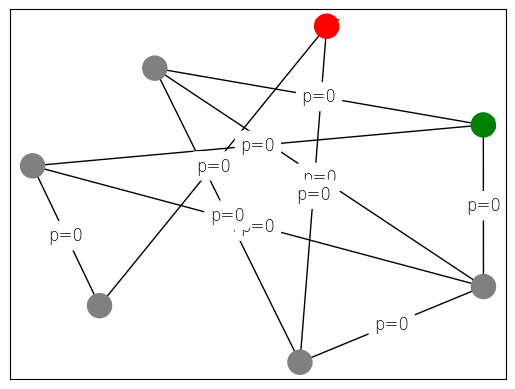

In [25]:
json_file = 'GoD_basic_graph.json'
with open(json_file, 'r') as f:
    data = json.load(f)

G = nx.node_link_graph(data)

# Now you can access the attributes
print("Node attributes:")
for node, attrs in G.nodes(data=True):
    print(f"{node}: {attrs}")

print("\nEdge attributes:")
for u, v, attrs in G.edges(data=True):
    print(f"{u}->{v}: {attrs}")



end_node = 7
start_node = 1
alpha = 0.5

print("Start of simulation:\n")
print(f"\tGraph parameters:\t{len(G.nodes)} nodes")
print(f"\t\t\t\t{len(G.edges)} edges")
print(f"\tstart node:\t\t{start_node}")
print(f"\ttarget_node:\t\t{end_node}")
print(f"\talpha:\t\t\t{alpha}")


nx.display(G, node_label=True, edge_label=True)

In [16]:
G

In [ ]:
def create_probability_graph(graph, jammer):
    """ Given a graph and  """
    
    prob_graph = nx.Graph()
    for u, v in graph.edges():
        distance_u = nx.shortest_path_length(graph, source=jammer, target=u) if jammer in graph else float('inf')
        distance_v = nx.shortest_path_length(graph, source=jammer, target=v) if jammer in graph else float('inf')

        min_distance = min(distance_u, distance_v)
        if min_distance == 0:
            prob = 0.5
        elif min_distance == 1:
            prob = 0.25
        else:
            prob = 0.0

        prob_graph.add_edge(u, v, survival_prob=1 - prob)
    return prob_graph

def calculate_risk(path, prob_graph):
    success_prob = 1.0
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        success_prob *= prob_graph[u][v]['survival_prob']
    return 1 - success_prob

def compute_payoff_matrix(graph, start, end, alpha):
    all_paths = list(nx.all_simple_paths(graph, source=start, target=end))
    max_length = max(len(path) - 1 for path in all_paths)

    payoff_matrix = {}
    for jammer in graph.nodes:
        prob_graph = create_probability_graph(graph, jammer)
        payoff_matrix[jammer] = {}

        for path in all_paths:
            risk = calculate_risk(path, prob_graph)
            length = len(path) - 1
            payoff = alpha * risk + (1 - alpha) * ((max_length - length) / max_length)
            payoff_matrix[jammer][tuple(path)] = payoff

    return payoff_matrix, all_paths